<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### References 

> This colab notebook were made by modifying references below: 
> - [Train a custom object detection model using your data](https://youtu.be/-ZyFYniGUsw)
> - [Model Maker Object Detection for Android Figurine](https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb)
> - [Object Detection with TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/tutorials/model_maker_object_detection)


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect UI objects and how to convert the TF lite model with TFJS.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [1]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install -q pycocotools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages.

In [1]:
from absl import logging
import tensorflow as tf
from tflite_support import metadata
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector


assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)


### Prepare the dataset

In this notebook, we're going to rearrange and use the RICO dataset. If you would like to manually build training and validation datasets, please click [this link](https://interactionmining.org/rico) and download RICO manually.

#### Downloading data from RICO dataset

In [ ]:
!curl -L "https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz" > jpg.tar.gz; tar -zxvf jpg.tar.gz; rm jpg.tar.gz
!curl -L "https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/semantic_annotations.zip" > json.zip; unzip json.zip; rm json.zip

Download two compressed files from RICO. Each file contains pairs of images and JSON files. We save space by deleting all files except for the original image files and annotation files we need.

In [ ]:
# remove unused pairs
!find combined/. -name '*.json' -type f -delete
!find combined/. -name "*.jpg" | wc -l
!find semantic_annotations/. -name '*.png' -type f -delete
!find semantic_annotations/. -name "*.json" | wc -l

#### Scaled images 

Most of RICO's screenshots are high-resolution images at 1440 × 2560 pixels. If you use these directly, they will use a lot of resources with regards to the GPU and memory within Google Colab's training environment.  

So we'll reduce all images to 640px height JPG. Later, we're going to change the value inside annotation files too.


In [ ]:
from PIL import Image
import os

raw_path = './combined/'  # source image path
data_path = './jpg/'  # Resized image path

# Start resize --------------------
# If there is no data_path, create
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Specify a list of all images in the source image path
data_list = os.listdir(raw_path)
print(len(data_list))

# Save all images after resizing
for name in data_list:
    im = Image.open(raw_path + name)
    im = im.resize((360, 640))
    im.save(data_path + name)
    print('end ::: ' + data_path + name)


#### Convert to XML

We'll extract only the necessary information such as such as the bounding box, filename, and component name from the JSON files and convert them to xml format.

During this conversion, I discovered some data had unexpected errors:

- Bounding box (bndbox) is sometimes negative
- Component’s xmax or ymax value is sometimes greater than the overall  width and height values of the screenshot
- xmin is sometimes greater than xmax or ymin is greater than ymax
- And so on…

So, I skipped all of those kinda errored items. Please check the isvalidbdnbox function below:

In [ ]:
import os
import json
from xml.etree.ElementTree import Element, SubElement

def beautify(elem, indent=0):
    """
    xml 트리를 문자열로 변환합니다.
    Converts the XML tree to a string.

    :param elem: xml element
    :param indent: Indent Level to display in front
    """
    result0 = f"{'    ' * indent}<{elem.tag}>"
    # 값이 있는 태그면 값을 바로 출력
    # If there is a value in the tag, immediately print the value
    if elem.text is not None:
        result0 += elem.text + f"</{elem.tag}>\n"
    # 값이 없고 자식 노드가 있으면 재귀 호출로 출력합니다.
    # If the tag has no value and has child nodes, call the recursive function.
    else:
        result0 += "\n"
        for _child in elem:
            result0 += beautify(_child, indent + 1)
        result0 += f"{'    ' * indent}</{elem.tag}>\n"
    return result0

def isvalidbdnbox(xmin,xmax,ymin,ymax):
    """
    Validate the bnd box.
    다중 if를 추가해서 bnd 박스를 검증해야 합니다.
    """
    # bounding box(bndbox)가 음수이면 안됩니다. 
    # bounding box(bndbox) cannot be negative.
    if(xmin<0 or xmax<0 or ymin<0 or ymax<0):
        print("bndbox cannot be negative.")
        return False
    # bndbox의 xmax 값은 1440, ymax 값은 2560을 넘으면 안됩니다. 
    # The xmax value of bndbox cannot exceed 1440 and the ymax value cannot exceed 2560.
    if(xmax>1440  or ymax>2560):
        print("bndbox cannot exceed the screenshot")
        return False

    # xmin 값은 xmax 보다 클 수 없습니다. 또는 ymin 값은 ymax 보다 클 수 없습니다. 
    # xmin cannot be greater than xmax or ymin cannot be greater than ymax.
    
    if(xmin>xmax  or ymin>ymax):
        print("xmin>xmax  or ymin>ymax")
        return False

    if(xmin==xmax or ymin==ymax):
        print("xmin=xmax or ymin=ymax")
        return False
        
    
    return True

def recursive(child, result_out):
    """
    원하는 역할을 하기 위해서 재귀호출을 할 수 있는 함수를 생성합니다.
    Create a function that makes a recursive call.
    """
    obj = Element("object")

    # Set bounds
    bounds = child['bounds']

    # Set name
    SubElement(obj, "name").text = child['componentLabel']
    # Set difficult, truncated, pose
    SubElement(obj, "difficult").text = '0'
    SubElement(obj, "truncated").text = 'Unspecified'
    SubElement(obj, "pose").text = 'Undefined'

    # Set bndbox 
    bndbox = SubElement(obj, "bndbox")
    xmin=bounds[0]
    ymin=bounds[1]
    xmax=bounds[2]
    ymax=bounds[3]
    
    if(isvalidbdnbox(xmin,xmax,ymin,ymax)):
        SubElement(bndbox, "xmin").text = str(round(xmin/4))
        SubElement(bndbox, "ymin").text = str(round(ymin/4))
        SubElement(bndbox, "xmax").text = str(round(xmax/4))
        SubElement(bndbox, "ymax").text = str(round(ymax/4))
        result_out.append(beautify(obj))

    
    # 생성한 object 태그를 문자열로 변환해서 추가합니다.
    # Convert the created object tag to a string and add it.
    if 'children' not in child:
        return

    # 자식 노드가 있는 경우 자식 노드에 대해 재귀 호출을 수행합니다.
    # If there is a child node, make a recursive call to the child node.
    for ch in child.get('children', []):
        recursive(ch, result_out)


def json2xml(infile, outfile):
    """
    json2xml function
    param infile :
    ourfile :
    """
    result_out = []
    imgName = infile.replace("./semantic_annotations/", "")
    imgName = imgName.replace("json", "jpg")

    # Read the file
    with open(infile, "r", encoding="UTF-8") as f:
        data = json.load(f)

    children = data['children']

    # 자식 노드에 대해 재귀 호출을 수행합니다.
    # Make a recursive call on child nodes.
    for child in children:
        recursive(child, result_out)

    # 그리고 해당 결과를 파일로 저장합니다.
    # And save the result to the XML file.
    with open(outfile, "w", encoding="UTF-8") as f:
        f.write("".join("<annotation><folder />"))
        f.write("".join("<filename>" + imgName + "</filename>\n"
                    "<path>" + imgName + "</path>\n"+
                    "<source><database>RICO</database></source><size><width>360</width><height>640</height><depth>3</depth></size><segmented>0</segmented> "))
        f.write("".join(result_out))
        f.write("".join("</annotation>"))


def search(mypath):
    onlyfiles = [f for f in os.listdir(mypath)
                 if os.path.isfile(os.path.join(mypath, f))]
    onlyfiles.sort()    
    return onlyfiles


def main():
    """
    메인 함수
    The main function 
    """
    data_path = './xml/'
    if not os.path.exists(data_path):
      os.mkdir(data_path)


    files = os.listdir('./semantic_annotations')
    # print(files)
    for infile in files:
        infile = f'./semantic_annotations/{infile}'
        outfile = infile.replace("semantic_annotations", "xml").replace("json", "xml")
        print(infile, outfile)
        json2xml(infile, outfile)


if __name__ == "__main__":
    main()

#### Generate Label Map

Next, we should generate the `label_map.pbtxt` based on XML file and also set the `label_map` array together.


In [2]:
import os
import xml.etree.ElementTree as ET

obj = []

for filename in os.listdir("./xml/"):
    # with open(os.path.join("xml", filename), 'r') as f:
    tree = ET.parse(os.path.join("./xml/", filename))
    root = tree.getroot()
    object = root.findall("object")
    name = [x.findtext("name") for x in object]

    for i in name:
        obj.append(i)

obj_unique = list(set(obj))

pbtxt = ""
label_map = []
for i in range(len(obj_unique)):
    pbtxt += "item {\n    name: \""+obj_unique[i]+"\",\n    id: "+str(i+1)+"\n}\n"+"\n"
    label_map.append(obj_unique[i])
    
with open("label_map.pbtxt", "w", encoding="utf-8") as f:
    f.write(pbtxt)

print(label_map)

['Image', 'Input', 'On/Off Switch', 'Date Picker', 'Map View', 'List Item', 'Advertisement', 'Card', 'Checkbox', 'Drawer', 'Web View', 'Radio Button', 'Video', 'Button Bar', 'Text', 'Bottom Navigation', 'Toolbar', 'Number Stepper', 'Text Button', 'Pager Indicator', 'Icon', 'Slider', 'Modal', 'Background Image', 'Multi-Tab']


#### Partition the dataset

Next, We're going to split our dataset into the desired training and testing subsets. Typically, the ratio is 9:1. 90% of the images are used for training and the rest 10% is maintained for testing, but you can chose whatever ratio suits your needs.

[Lyudmil Vladimirov](https://github.com/sglvladi) has published a great code example on [splitting the dataset](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#partition-the-dataset).

In [ ]:
import os
import re
from shutil import copyfile
import argparse
import math
import random


def iterate_dir(source, dest, ratio, xml_source):
    source = source.replace('\\', '/')
    xml_source = xml_source.replace('\\', '/')
    dest = dest.replace('\\', '/')
    train_dir = os.path.join(dest, 'train')
    test_dir = os.path.join(dest, 'test')

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    images = [f for f in os.listdir(source)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]

    num_images = len(images)
    num_test_images = math.ceil(ratio*num_images)

    for i in range(num_test_images):
        idx = random.randint(0, len(images)-1)
        filename = images[idx]
        copyfile(os.path.join(source, filename),os.path.join(test_dir, filename))
        
        xml_filename = os.path.splitext(filename)[0]+'.xml'
        copyfile(os.path.join(xml_source, xml_filename),os.path.join(test_dir, xml_filename))
        images.remove(images[idx])

    for filename in images:
        copyfile(os.path.join(source, filename),os.path.join(train_dir, filename))
        
        xml_filename = os.path.splitext(filename)[0]+'.xml'
        copyfile(os.path.join(xml_source, xml_filename),os.path.join(train_dir, xml_filename))
            
def main():

    imageDir = './jpg/'
    outputDir = './'
    ratio = 0.1
    xmlDir = './xml/'

    # Now we are ready to start the iteration
    iterate_dir(imageDir, outputDir, ratio, xmlDir)


if __name__ == '__main__':
    main()

In [3]:
# (optional) Leave only the necessary files.

!find train/. | wc -l
!find test/. | wc -l

%rm -rf semantic_annotations combined jpg
# %rm -rf test train

119269
13255


UsageError: Line magic function `%rm` not found.


## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [4]:
# print(label_map)
train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir='./train',
    annotations_dir='./train',
    label_map=label_map
)

val_data = object_detector.DataLoader.from_pascal_voc(
    images_dir='./test',
    annotations_dir='./test',
    label_map=label_map
)


### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* |Latency(ms)**	| Average Precision*** |
|--------------------|-----------|--------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 	37          | 25.69%               |
| EfficientDet-Lite1 | 5.8       |  49          | 30.55%               |
| EfficientDet-Lite2 | 7.2       |  69          | 33.97%               |
| EfficientDet-Lite3 | 11.4      |  116         | 37.70%               |
| EfficientDet-Lite4 | 19.9      |  260         | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU.<br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you. 

**note:** You might need to pass the max instance number as an hparam when the model is created due to huge volume of RICO dataset. Set the `max_instances_per_image` slightly higher than the max number of objects you expect to see in an image.

In [5]:
spec = object_detector.EfficientDetSpec(model_name='efficientdet-lite0', uri='https://tfhub.dev/tensorflow/efficientdet/lite0/feature-vector/1', hparams={'max_instances_per_image': 8000})

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 16` here so you will see that it takes  3,727 steps to go through the all screenshots in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [6]:
model = object_detector.create(train_data=train_data, model_spec=spec, batch_size=16, train_whole_model=True, epochs=20, validation_data=val_data)

Epoch 1/20
3727/3727 [==============================] - 17525s 5s/step - det_loss: 1.0959 - cls_loss: 0.6612 - box_loss: 0.0087 - reg_l2_loss: 0.0672 - loss: 1.1631 - learning_rate: 0.0140 - gradient_norm: 1.4641 - val_det_loss: 1.0653 - val_cls_loss: 0.6432 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0673 - val_loss: 1.1326
Epoch 2/20
3727/3727 [==============================] - 17482s 5s/step - det_loss: 0.9268 - cls_loss: 0.5615 - box_loss: 0.0073 - reg_l2_loss: 0.0674 - loss: 0.9942 - learning_rate: 0.0197 - gradient_norm: 1.2754 - val_det_loss: 0.9822 - val_cls_loss: 0.5799 - val_box_loss: 0.0080 - val_reg_l2_loss: 0.0675 - val_loss: 1.0497
Epoch 3/20
3727/3727 [==============================] - 17462s 5s/step - det_loss: 0.8908 - cls_loss: 0.5412 - box_loss: 0.0070 - reg_l2_loss: 0.0675 - loss: 0.9582 - learning_rate: 0.0191 - gradient_norm: 1.2383 - val_det_loss: 0.9547 - val_cls_loss: 0.5637 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0674 - val_loss: 1.0221
Epoch 4/20
3727/372

### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the screenshots in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the screenshots in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [7]:
model.evaluate(val_data)

104/104 [==============================] - 442s 4s/step



{'AP': 0.23928128,
 'AP50': 0.34784698,
 'AP75': 0.26955733,
 'APs': 0.028244007,
 'APm': 0.12941888,
 'APl': 0.22108501,
 'ARmax1': 0.2461824,
 'ARmax10': 0.35139942,
 'ARmax100': 0.36341742,
 'ARs': 0.054406602,
 'ARm': 0.19773099,
 'ARl': 0.34407103,
 'AP_/Image': 0.16317038,
 'AP_/Input': 0.08524754,
 'AP_/On/Off Switch': 0.048255134,
 'AP_/Date Picker': 0.35675347,
 'AP_/Map View': 0.17753105,
 'AP_/List Item': 0.28585535,
 'AP_/Advertisement': 0.28919548,
 'AP_/Card': 0.20789924,
 'AP_/Checkbox': 0.1734771,
 'AP_/Drawer': 0.68573767,
 'AP_/Web View': 0.19177885,
 'AP_/Radio Button': 0.057744134,
 'AP_/Video': 0.0060326965,
 'AP_/Button Bar': 0.0023122337,
 'AP_/Text': 0.105855204,
 'AP_/Bottom Navigation': 0.3663874,
 'AP_/Toolbar': 0.5422325,
 'AP_/Number Stepper': 0.35072106,
 'AP_/Text Button': 0.2381703,
 'AP_/Pager Indicator': 0.000990099,
 'AP_/Icon': 0.34229085,
 'AP_/Slider': 0.0,
 'AP_/Modal': 0.63886,
 'AP_/Background Image': 0.46593183,
 'AP_/Multi-Tab': 0.19960245}

### Step 5: Export as a TensorFlow Lite model with TFJS format.

Export the trained object detection model to the TensorFlow JS format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). 

In [8]:
# ExportFormat.TFJS is not yet supported
# model.export(export_dir="./js_export/", export_format=[ExportFormat.TFJS])

model.export(export_dir="./js_export/", export_format=[ExportFormat.SAVED_MODEL])
!zip -r ./js_export/ModelFiles.zip ./js_export/

'zip'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


## (Optional) Test the detection model with TensorFlow lite

Let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In this example, we will extract one more tflite model and test how well the model actually works. This result may be slightly different from that of TFJS, so it is recommended to use it for reference only.

In [9]:
model.export(export_dir='.', tflite_filename='rico.tflite')
model.evaluate_tflite('rico.tflite', val_data)

6627/6627 [==============================] - 27236s 4s/step



{'AP': 0.20490232,
 'AP50': 0.2911546,
 'AP75': 0.23508495,
 'APs': 0.021943321,
 'APm': 0.115160994,
 'APl': 0.18580821,
 'ARmax1': 0.2026951,
 'ARmax10': 0.26787397,
 'ARmax100': 0.26974252,
 'ARs': 0.032209698,
 'ARm': 0.15022126,
 'ARl': 0.24558628,
 'AP_/Image': 0.123515174,
 'AP_/Input': 0.07007123,
 'AP_/On/Off Switch': 0.045216367,
 'AP_/Date Picker': 0.22942775,
 'AP_/Map View': 0.1260201,
 'AP_/List Item': 0.22389112,
 'AP_/Advertisement': 0.23017684,
 'AP_/Card': 0.11379653,
 'AP_/Checkbox': 0.14040026,
 'AP_/Drawer': 0.65390044,
 'AP_/Web View': 0.14987761,
 'AP_/Radio Button': 0.03745377,
 'AP_/Video': 0.026732674,
 'AP_/Button Bar': 0.0,
 'AP_/Text': 0.07595385,
 'AP_/Bottom Navigation': 0.38563696,
 'AP_/Toolbar': 0.5175326,
 'AP_/Number Stepper': 0.3151305,
 'AP_/Text Button': 0.21079078,
 'AP_/Pager Indicator': 0.0014851486,
 'AP_/Icon': 0.3101346,
 'AP_/Slider': 0.0,
 'AP_/Modal': 0.5949396,
 'AP_/Background Image': 0.41141692,
 'AP_/Multi-Tab': 0.12905711}

In [10]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


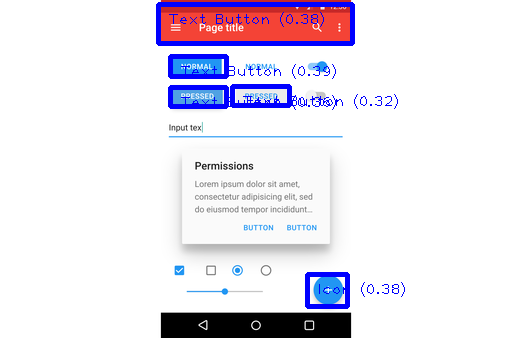

In [18]:
#@title Run object detection and show the detection results

from PIL import Image

INPUT_IMAGE_URL = "https://miro.medium.com/max/1400/1*besTuD-m9aktHEJ2VRhCAA.png" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}
TFLITE_MODEL_PATH = "rico.tflite" #@param {type:"string"}

TEMP_FILE = 'image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)